In [9]:
import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
from PIL import Image
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

from smooth_tiled_predictions import predict_img_with_smooth_windowing
from simple_multi_unet_model import jacard_coef 

In [22]:
img = cv2.imread("/media/ExtHDD01/ankit_vaghasiya/sematic_segmentation_unet/test/images/2012-04-26-Muenchen-Tunnel_4K0G0040.jpg", 1)
original_mask = cv2.imread("/media/ExtHDD01/ankit_vaghasiya/sematic_segmentation_unet/train/labels/rgb/2012-04-26-Muenchen-Tunnel_4K0G0020.png", 1)
original_mask = cv2.cvtColor(original_mask,cv2.COLOR_BGR2RGB)

In [23]:
# weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
# dice_loss = sm.losses.DiceLoss(class_weights=weights) 
# focal_loss = sm.losses.CategoricalFocalLoss()
# total_loss = dice_loss + (2 * focal_loss)  #

from keras.models import load_model

model = load_model("/media/ExtHDD01/ankit_vaghasiya/sematic_segmentation_unet/hdf5_trained_model_29march24.hdf5", compile=False)
                  
# size of patches
patch_size = 256

# Number of classes 
n_classes = 2

1/1 [==============================] - 0s 25ms/step


(-0.5, 5375.5, 3583.5, -0.5)

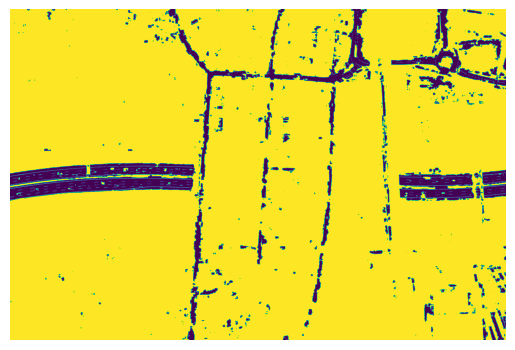

In [24]:
#################################################################################
#Predict patch by patch with no smooth blending
###########################################

SIZE_X = (img.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
SIZE_Y = (img.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
large_img = Image.fromarray(img)
large_img = large_img.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
#image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
large_img = np.array(large_img)     


patches_img = patchify(large_img, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
patches_img = patches_img[:,:,0,:,:,:]

patched_prediction = []
for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
        
        single_patch_img = patches_img[i,j,:,:,:]
        
        #Use minmaxscaler instead of just dividing by 255. 
        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
        single_patch_img = np.expand_dims(single_patch_img, axis=0)
        pred = model.predict(single_patch_img)
        pred = np.argmax(pred, axis=3)
        pred = pred[0, :,:]
                                 
        patched_prediction.append(pred)

patched_prediction = np.array(patched_prediction)
patched_prediction = np.reshape(patched_prediction, [patches_img.shape[0], patches_img.shape[1], 
                                            patches_img.shape[2], patches_img.shape[3]])

unpatched_prediction = unpatchify(patched_prediction, (large_img.shape[0], large_img.shape[1]))

plt.imshow(unpatched_prediction)
plt.axis('off')

In [25]:
input_img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)

# Use the algorithm. The `pred_func` is passed and will process all the image 8-fold by tiling small patches with overlap, called once with all those image as a batch outer dimension.
# Note that model.predict(...) accepts a 4D tensor of shape (batch, x, y, nb_channels), such as a Keras model.
predictions_smooth = predict_img_with_smooth_windowing(
    input_img,
    window_size=patch_size,
    subdivisions=2,  # Minimal amount of overlap for windowing. Must be an even number.
    nb_classes=n_classes,
    pred_func=(
        lambda img_batch_subdiv: model.predict((img_batch_subdiv))
    )
)


final_prediction = np.argmax(predictions_smooth, axis=2)


  0%|          | 0/8 [00:00<?, ?it/s]

42/42 [==============================] - 1s 20ms/step


 12%|█▎        | 1/8 [00:12<01:27, 12.44s/it]

42/42 [==============================] - 1s 20ms/step


 25%|██▌       | 2/8 [00:25<01:16, 12.68s/it]

42/42 [==============================] - 1s 20ms/step


 38%|███▊      | 3/8 [00:34<00:56, 11.22s/it]

42/42 [==============================] - 1s 20ms/step


 50%|█████     | 4/8 [00:45<00:43, 10.85s/it]

42/42 [==============================] - 1s 20ms/step


 62%|██████▎   | 5/8 [00:54<00:30, 10.33s/it]

42/42 [==============================] - 1s 25ms/step


 75%|███████▌  | 6/8 [01:04<00:20, 10.31s/it]

42/42 [==============================] - 1s 20ms/step


 88%|████████▊ | 7/8 [01:14<00:10, 10.04s/it]

42/42 [==============================] - 1s 21ms/step


100%|██████████| 8/8 [01:24<00:00, 10.59s/it]


In [26]:
###################################################################################
#Predict using smooth blending


###################
#Convert labeled images back to original RGB colored masks. 

def label_to_rgb(predicted_image):
    
    """ Building = '#3C1098'.lstrip('#')
    Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

    Land = '#8429F6'.lstrip('#')
    Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246 """

    Road = '#66669c'.lstrip('#') 
    Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228
    print(Road)

    """ Vegetation =  'FEDD3A'.lstrip('#') 
    Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

    Water = 'E2A929'.lstrip('#') 
    Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41 """

    Unlabeled = '#000000'.lstrip('#') 
    Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155
    print(Unlabeled)
        
    
    
    segmented_img = np.empty((predicted_image.shape[0], predicted_image.shape[1], 3))
    
    """ segmented_img[(predicted_image == 0)] = Building
    segmented_img[(predicted_image == 1)] = Land """
    segmented_img[(predicted_image == 0)] = Road
    """ segmented_img[(predicted_image == 3)] = Vegetation
    segmented_img[(predicted_image == 4)] = Water """
    segmented_img[(predicted_image == 1)] = Unlabeled
    
    segmented_img = segmented_img.astype(np.uint8)
    return(segmented_img)


[102 102 156]
[0 0 0]
[102 102 156]
[0 0 0]


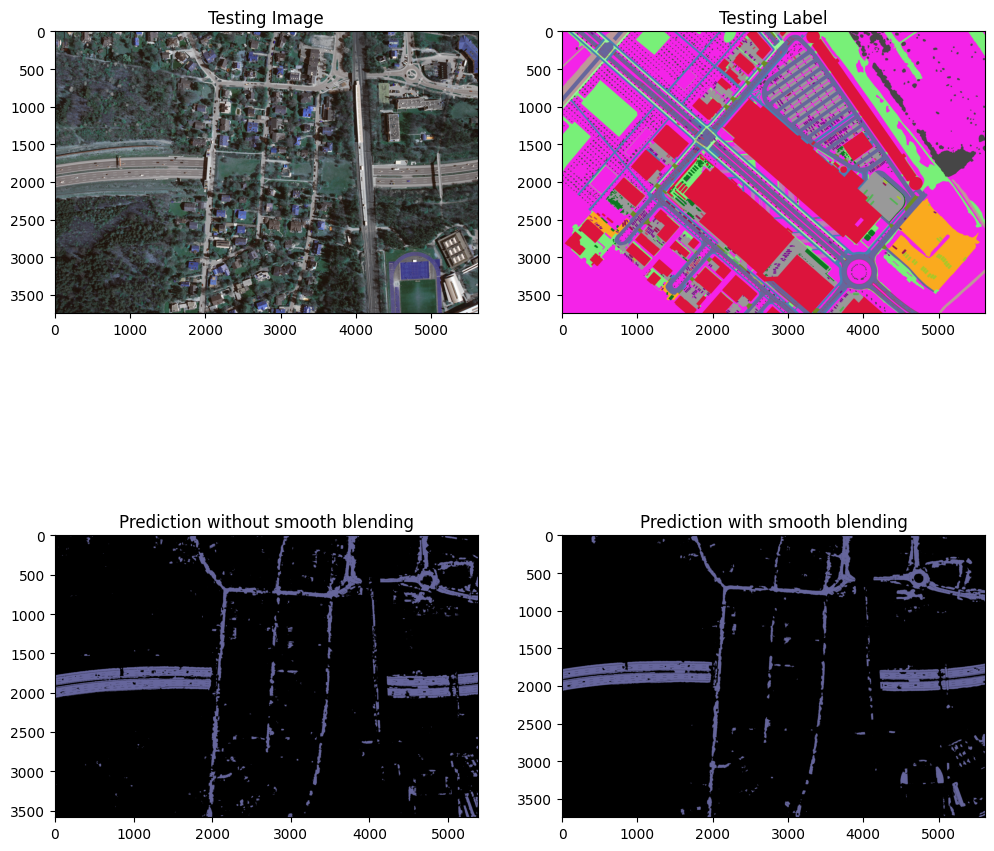

In [28]:
########################
#Plot and save results
prediction_with_smooth_blending=label_to_rgb(final_prediction)
prediction_without_smooth_blending=label_to_rgb(unpatched_prediction)


plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.title('Testing Image')
plt.imshow(img)
plt.subplot(222)
plt.title('Testing Label')
plt.imshow(original_mask)
plt.subplot(223)
plt.title('Prediction without smooth blending')
plt.imshow(prediction_without_smooth_blending)
plt.subplot(224)
plt.title('Prediction with smooth blending')
plt.imshow(prediction_with_smooth_blending)
plt.show()

#############################

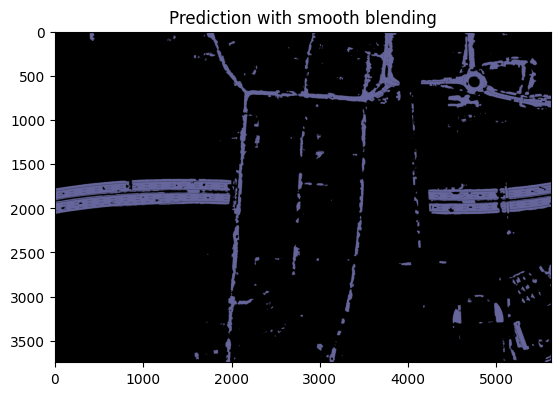

In [29]:
plt.title('Prediction with smooth blending')
plt.imshow(prediction_with_smooth_blending)
plt.show()
#save this plot
plt.imsave('prediction_with_smooth_blending.png', prediction_with_smooth_blending)